In [1]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

In [2]:
# intel accelerate
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Load Data

In [ ]:
# Train Data
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]

train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]

print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))

In [44]:
# Test Data
# Data path
test_transaction_path = "data/test_transaction.csv"
test_identity_path = "data/test_identity.csv"

#Read data
test_transaction = pd.read_csv(test_transaction_path)
test_identity = pd.read_csv(test_identity_path)

test_df = pd.merge(test_identity, test_transaction, on="TransactionID", how='right')

test_df_row = test_df.shape[0]
test_df_col = test_df.shape[1]
print('Testing DataFrame: {} rows & {} columns.'.format(test_df_row, test_df_col))

Testing DataFrame: 506691 rows & 433 columns.


In [15]:
# #Data path
# train_transaction_path = "data/train_transaction.csv"
# train_identity_path = "data/train_identity.csv"
# test_transaction_path = "data/test_transaction.csv"
# test_identity_path = "data/test_identity.csv"
# sample_submission_path = "data/sample_submission.csv"

# #Read data
# train_transaction = pd.read_csv(train_transaction_path)
# train_identity = pd.read_csv(train_identity_path)
# test_transaction = pd.read_csv(test_transaction_path)
# test_identity = pd.read_csv(test_identity_path)
# sample_submission = pd.read_csv(sample_submission_path)

# train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
# test_df = pd.merge(test_identity, test_transaction, on="TransactionID", how='right')
# train_transaction_row = train_transaction.shape[0]
# train_transaction_col = train_transaction.shape[1]
# train_identity_row = train_identity.shape[0]
# train_identity_col = train_identity.shape[1]

# train_df_row = train_df.shape[0]
# train_df_col = train_df.shape[1]
# test_df_row = test_df.shape[0]
# test_df_col = test_df.shape[1]

# print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
# print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
# print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))
# print('Testing DataFrame: {} rows & {} columns.'.format(test_df_row, test_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 590540 rows & 434 columns.
Testing DataFrame: 506691 rows & 433 columns.


In [16]:
# release data from original dataframes
del train_transaction
del train_identity
del test_transaction
del test_identity

### Time

In [17]:
## Day of week (one hot)
def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

# Hour of day (one hot)
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def addr1_transform(x):
    if x in top_ten_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_ten_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_twenty_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_twenty_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

In [18]:
print(min(train_df['TransactionDT']))
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)


86400


### Transaction Amound, Email, & Address

In [19]:
# old codes: top encoding
# #addr1, addr2
# top_ten_addr1 = list(train_df['addr1'].value_counts().index)[:10] #top ten regions
# top_ten_addr2 = list(train_df['addr2'].value_counts().index)[:10] #top ten countries
# train_df['addr1_new'] = train_df['addr1'].apply(addr1_transform)
# train_df['addr2_new'] = train_df['addr2'].apply(addr2_transform)
# #Email_Domain
# top_twenty_email_p = list(train_df['P_emaildomain'].value_counts().index)[:20] #top ten regions
# top_twenty_email_r = list(train_df['R_emaildomain'].value_counts().index)[:20] #top ten countries
# train_df['P_emaildomain'].value_counts()
# train_df['P_emaildomain_new'] = train_df['P_emaildomain'].apply(email_p_transform)
# train_df['R_emaildomain_new'] = train_df['R_emaildomain'].apply(email_r_transform)

In [20]:
# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))
# convert this into sklearn transformers when have time

Following are with some kinds of frequency encoding

In [21]:
# Email_p
def email_p(x):
    if x in safe_p_email:
        return 0
    elif x in sus_p_email:
        return 20
    elif x in fraud_p_email:
        return 50
    elif x == 'Missing':
        return -1
    else:
        return 1
    
table_p = pd.pivot_table(train_df, values='TransactionID', index=['P_emaildomain'], columns=['isFraud'], aggfunc='count')
table_p['sum'] = table_p.sum(axis=1)
table_p['0_%'] = table_p[0] / table_p['sum']
table_p['1_%'] = table_p[1] / table_p['sum']
# # # table[[0, 1]]
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_p[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 
#P_emaildomain
safe_p_email = list(table_p[table_p['1_%'].isnull()].index)
sus_p_email = ['aim.com', 'mail.com', 'outlook.es', 'outlook.com']
fraud_p_email = ['protonmail.com']

In [22]:
# Email_r
def email_r(x):
    if x in safe_r_email:
        return 0
    elif x in sus_r_email:
        return 5
    elif x in fraud_r_email:
        return 20
    elif x in death_r_email:
        return 95
    elif x == 'Missing':
        return -1
    else:
        return 1
table_r = pd.pivot_table(train_df, values='TransactionID', index=['R_emaildomain'], columns=['isFraud'], aggfunc='count')
table_r['sum'] = table_r.sum(axis=1)
table_r['0_%'] = table_r[0] / table_r['sum']
table_r['1_%'] = table_r[1] / table_r['sum']
# # # table[[0, 1]]
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_r[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 
#R_emaildomain
safe_r_email = list(table_r[table_r['1_%'].isnull()].index)
sus_r_email = ['earthlink.net', 'gmail.com', 'hotmail.com', 'hotmail.es', 'icloud.com'] #5
fraud_r_email = ['mail.com', 'netzero.net', 'outlook.com', 'outlook.es'] #20
death_r_email = ['protonmail.com']  #95

In [23]:
train_df['email_p_score'] = train_df['P_emaildomain'].apply(email_p)
train_df['email_r_score'] = train_df['R_emaildomain'].apply(email_r)

In [24]:
# Address 1
table_a1 = pd.pivot_table(train_df, values='TransactionID', index=['addr1'], columns=['isFraud'], aggfunc='count')
table_a1['sum'] = table_a1.sum(axis=1)
table_a1['0_%'] = table_a1[0] / table_a1['sum']
table_a1['1_%'] = table_a1[1] / table_a1['sum']
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_a1[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 
table_a1 = table_a1.fillna(0) # there is fillna here
a1_df = table_a1[['1_%']]
a1_df['index'] = a1_df.index
addr1_val = list(table_a1.index)
addr1_dict = {}
for i in range(len(addr1_val)):
    addr1_dict[addr1_val[i]] = a1_df.loc[addr1_val[i], '1_%']
addr1_df = train_df[['addr1']].fillna(-2)
train_df['addr1'] = addr1_df['addr1'].copy()
train_df['addr1_score'] = train_df['addr1'].apply(lambda x: -2 if x == -2 else addr1_dict[x])

In [25]:
# Address 2
table_a2 = pd.pivot_table(train_df, values='TransactionID', index=['addr2'], columns=['isFraud'], aggfunc='count')
table_a2['sum'] = table_a2.sum(axis=1)
table_a2['0_%'] = table_a2[0] / table_a2['sum']
table_a2['1_%'] = table_a2[1] / table_a2['sum']
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_a2[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 
table_a2 = table_a2.fillna(0) # there is fillna here
a2_df = table_a2[['1_%']]
a2_df['index'] = a2_df.index
addr2_val = list(table_a2.index)
addr2_dict = {}
for i in range(len(addr2_val)):
    addr2_dict[addr2_val[i]] = a2_df.loc[addr2_val[i], '1_%']
addr2_df = train_df[['addr2']].fillna(-2)
train_df['addr2'] = addr2_df['addr2'].copy()
train_df['addr2_score'] = train_df['addr2'].apply(lambda x: -2 if x == -2 else addr2_dict[x])

### One-Hot Encoding

In [26]:
# list for one-hot
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour',
                'ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log', 'email_p_score', 'email_r_score', 'addr2_score', 'addr1_score']

to_ohe = train_df[one_hot_lst]
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(to_ohe)
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())
v_data = train_df.iloc[:, 95:434].fillna(0).to_numpy()
nums_part = train_df[num_list]
v = pd.DataFrame(v_data)
nums = pd.concat([nums_part, v], axis = 1)

In [27]:
X = pd.concat([nums, cates], axis=1)
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]
xxx = X.columns

### Train Test Split

In [28]:
#Raw Ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=590540)

### XGBoost Decision Tree - Raw Ratio

In [29]:
#Raw Ratio
def XGBoost_DT(X_train, X_test, y_train, y_test):
    xgb_cl = xgb.XGBClassifier()
    xgb_cl.fit(X_train, y_train)
    preds = xgb_cl.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = xgb_cl.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [30]:
xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = XGBoost_DT(X_train, X_test, y_train, y_test)

[12:56:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


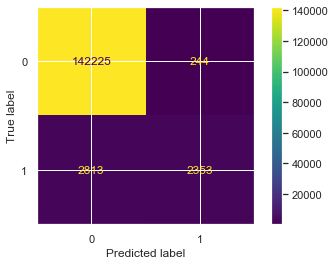

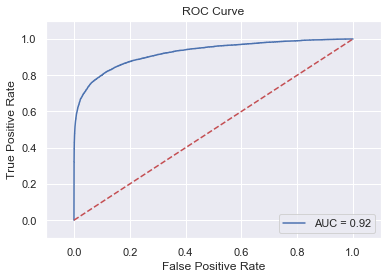

In [31]:
plot_confusion_matrix(xgb_cl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [55]:
test_df.columns.tolist()

['TransactionID',
 'id-01',
 'id-02',
 'id-03',
 'id-04',
 'id-05',
 'id-06',
 'id-07',
 'id-08',
 'id-09',
 'id-10',
 'id-11',
 'id-12',
 'id-13',
 'id-14',
 'id-15',
 'id-16',
 'id-17',
 'id-18',
 'id-19',
 'id-20',
 'id-21',
 'id-22',
 'id-23',
 'id-24',
 'id-25',
 'id-26',
 'id-27',
 'id-28',
 'id-29',
 'id-30',
 'id-31',
 'id-32',
 'id-33',
 'id-34',
 'id-35',
 'id-36',
 'id-37',
 'id-38',
 'DeviceType',
 'DeviceInfo',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15

In [48]:
train_df.columns.tolist()

['TransactionID',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 

In [36]:
### Preparing Test Set
# test_df = test_df.drop(columns=['id-21', 'id-22', 'id-23', 'id-04', 'id-25', 'id-26','id-27','id-01','id-07','id-08'])

In [13]:
test_df.shape

(506691, 433)

In [14]:
#min(train_df['TransactionDT']) #86506

In [15]:
#min(test_df['TransactionDT']) #18404013

In [49]:
test_df['TransactionDT'] = test_df['TransactionDT'] - min(train_df['TransactionDT'])
test_df['TransactionDayOfWeek'] = test_df['TransactionDT'].apply(convert_day_of_week)
test_df['TransactionHour'] = test_df['TransactionDT'].apply(convert_hour)
# Transaction Amount (Log)
test_df['TransactionAmt_log'] = test_df['TransactionAmt'].apply(lambda x: np.log(x))
# #addr1, addr2
# top_ten_addr1 = list(test_df['addr1'].value_counts().index)[:10] #top ten regions
# top_ten_addr2 = list(test_df['addr2'].value_counts().index)[:10] #top ten countries
# test_df['addr1_new'] = test_df['addr1'].apply(addr1_transform)
# test_df['addr2_new'] = test_df['addr2'].apply(addr2_transform)
# #Email_Domain
# top_twenty_email_p = list(test_df['P_emaildomain'].value_counts().index)[:20] #top ten regions
# top_twenty_email_r = list(test_df['R_emaildomain'].value_counts().index)[:20] #top ten countries
# test_df['P_emaildomain'].value_counts()
# test_df['P_emaildomain_new'] = test_df['P_emaildomain'].apply(email_p_transform)
# test_df['R_emaildomain_new'] = test_df['R_emaildomain'].apply(email_r_transform)

In [50]:
# Email
test_df['email_p_score'] = test_df['P_emaildomain'].fillna('Missing').apply(email_p)
test_df['email_r_score'] = test_df['R_emaildomain'].fillna('Missing').apply(email_r)

In [51]:
# Addr1 
test_df['addr1'] = test_df['addr1'].fillna(-2)
test_df['addr1_score'] = test_df['addr1'].apply(lambda x: addr1_dict[x] if x in addr1_dict else (-2 if x == -2 else -1))
# Addr2
test_df['addr2'] = test_df['addr2'].fillna(-2)
test_df['addr2_score'] = test_df['addr2'].apply(lambda x: addr2_dict[x] if x in addr2_dict else (-2 if x == -2 else -1))

In [53]:
test_df.shape

(506691, 440)

In [54]:
train_df.shape

(590540, 441)

In [56]:
test_df.columns = list(train_df.drop(columns=['isFraud']).columns)

In [57]:
ohe_features = ohe.transform(test_df[one_hot_lst])
cates = pd.DataFrame(ohe_features.toarray())
v_data = test_df.iloc[:, 94:433].fillna(0).to_numpy()
nums_part = test_df[num_list]
v = pd.DataFrame(v_data)
nums = pd.concat([nums_part, v], axis = 1)
X = pd.concat([nums, cates], axis=1)
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]
preds = xgb_cl.predict(X)
test_df['isFraud'] = pd.Series(preds)
submission = test_df[['TransactionID', 'isFraud']]
submission.to_csv("submission_basline_frequency_encoding.csv", index=False)

In [19]:
submission

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0
